In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *
import dunestyle.matplotlib as dunestyle

plt.rcParams.update({
                     'figure.figsize': [8,6],
                     'xtick.labelsize': 'x-large',
                     'ytick.labelsize': 'x-large',
                     'figure.autolayout': True,
                     })
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from PIDA_class import PIDA

from pida_functions import *

DUNE plot style enabled


In [2]:
def loaddata(path:str, entry_stop=None, forceit=False):
    parquet_path= path.replace(".root", ".parquet")
    if os.path.isfile(parquet_path) and not forceit:
        print(path, 'loaded parquet')
        df = pl.read_parquet(parquet_path)
        return df
    pid = PIDA(path, entry_stop=entry_stop)
    dfs:pl.DataFrame
    dfv:pl.DataFrame
    df:pl.DataFrame

    dfs = pid.dfsingles
    dfv = pid.dfvector
    dfp = pid.dfplanes

    df = dfs.join(dfv, on=selection_events())
    df = df.join(dfp, on=selection_events())
    df.write_parquet(file=parquet_path)
    return df

df = loaddata("/home/henrique/Documents/Atmos_Pandora/data/pida/pida_new_full_extra.root")
# df = pl.scan_parquet("/home/henrique/Documents/Atmos_Pandora/data/pida/pida_new.parquet")
# df = pl.scan_parquet("data/pida_new_full.parquet")

/home/henrique/Documents/Atmos_Pandora/data/pida/pida_new_full_extra.root loaded parquet


In [3]:
dfall = df.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfall = dfall.with_columns(
    pnc = pl.col('trkpurity')*pl.col('trkcompleteness'),
)
dfmu = dfall.sort('trklen').filter(
    True,
    pl.col('trkPFPIsTrack'),
).group_by(selection_events()).agg(
    pl.all().last(),
).filter(
    pl.col('trkg4pdg').abs()==13,
    pl.col('trkg4mother')==0,
    pl.col('trklen')>0,
).sort('pnc').group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)


In [5]:
from scipy.interpolate import interp1d
Range_grampercm = np.array([9.833E-1, 1.786E0, 3.321E0,
       6.598E0, 1.058E1, 3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
       2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3, 1.758E3, 2.297E3,
       4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4,
       4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])
KE_MeV = np.array([ 10, 14,
       20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
       4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
       200000, 300000, 400000 ])
KE_GeV = KE_MeV/1e3
mu_mom = np.sqrt(KE_GeV*(KE_GeV+2*0.1057))
binsx=np.logspace(-2,2,200)
binsy=np.logspace(-1,3.5,200)
MuMomentum2Range = interp1d(mu_mom, Range_grampercm/1.4, 'cubic')

# plt.scatter(mu_mom,Range_grampercm/1.4, c='red')

# x = np.logspace(-1, 2, 200)
# y = MuMomentum2Range(x)
# plt.plot(x, y)

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Muon Momentum (GeV)')
# plt.ylabel('Drifted path length (cm)')
# csda = [plt.Line2D([0], [0], color='red', lw=2)]
# plt.legend(csda, ['CSDA Table'], loc='upper left')

In [6]:
dfmu = dfmu.with_columns(
        E = (pl.col('lepen')),
        p = (pl.col('lepen')**2 + pl.col('lepmass')**2).sqrt(),
        # Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>-1).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        pllhd = pl.when(pl.col("trkmomllhd")>-1).then(pl.col("trkmomllhd")).otherwise(0.),
        pchi2 = pl.when(pl.col("trkmomchi2")>-1).then(pl.col("trkmomchi2")).otherwise(0.),
        prange = pl.col('trkmomrange_mu'),
    ).with_columns(
        explen = pl.col('p').map_elements(lambda x: MuMomentum2Range(x), return_dtype=pl.Float64),
        Ellhd = pl.when(pl.col('trkmomllhd')>0).then((pl.col('pllhd')**2  + 0.1057**2).sqrt()).otherwise(0),
        Echi2 = pl.when(pl.col('trkmomchi2')>0).then((pl.col('pchi2')**2  + 0.1057**2).sqrt()).otherwise(0),
        Erange = (pl.col('prange')**2  + 0.1057**2).sqrt(),
    ).with_columns(
        Ereco = pl.when(pl.col('trkIsContained')==1).then(pl.col('Erange')).otherwise(
            pl.col('Ellhd')
        ),
        fraclen = pl.col('trklen')/pl.col('explen')
        # Ereco2 = pl.when(pl.col('LongestTrackContNumu')==1).then(pl.col('Erange')).otherwise(
        #     # pl.when(pl.col('Echi2')>2).then(pl.col('Echi2')).otherwise(pl.col('Ellhd'))
        #     pl.when(pl.col('Echi2')>2).then(pl.max_horizontal('Echi2','Ellhd')).otherwise(pl.col('Ellhd'))
        # )
    )

In [343]:
from scipy.stats import binned_statistic_2d

def SetDUNELogoColors():
    """ Set the color cycler to use the subset of Okabe-Ito colors that overlap with the DUNE logo colors. """

    from cycler import cycler
    cyc = cycler(color=['#D55E00', '#56B4E9', '#009E73', '#E69F00' ])
    plt.rc("axes", prop_cycle=cyc)
def resolution_plot(data_list, labels=None, true_x='fraclen', true="trkg4en", reco="Ellhd", legloc='best', Lbins = np.linspace(0, 1.0,80)):
    Ebins = np.logspace(-1, 1, 60)
    # Ebins = np.linspace(0, 10, 100)
    if not isinstance(data_list, list):
        data_list = [data_list]
    if isinstance(labels, list):
        assert(len(data_list) == len(labels))
    else:
        labels = [""] * len(data_list)
    
    SetDUNELogoColors()

    for data, label in zip(data_list, labels):
        data = data.filter(pl.col(reco)>0)
        bias = binned_statistic(data[true_x], data[reco]/data[true] - 1, bins=Lbins, statistic='mean').statistic
        # std = binned_statistic(data[true_x], data[reco]/data[true] - 1, bins=Ebins, statistic=manual_std).statistic
        std = binned_statistic_2d(data[true_x], data[true], data[reco], bins=[Lbins, Ebins], statistic=manual_std).statistic
        count = binned_statistic_2d(data[true_x], data[true], data[reco], bins=[Lbins, Ebins], statistic='count').statistic
        bias2d = binned_statistic_2d(data[true_x], data[true], data[reco], bins=[Lbins, Ebins], statistic='mean').statistic
        std = np.nan_to_num(std)
        bias2d = np.nan_to_num(bias2d)
        count_per_length = np.sum(count, axis=1)
        res_per_length = np.divide(std, bias2d, out=np.zeros_like(std), where=bias2d!=0)
        std = np.sum( res_per_length*count, axis=1)
        std = np.nan_to_num(std)
        std = np.divide(std, count_per_length, out=np.zeros_like(std), where=count_per_length!=0)

        
        # recomean = binned_statistic(data[true_x], data[reco], bins=Lbins, statistic='mean').statistic
        # std=std/recomean
        
        plt.fill_between(0.5*(Lbins[:-1] + Lbins[1:]), bias - std/2, bias + std/2, alpha=0.5, label=fr'Relative resolution')
        plt.plot(0.5*(Lbins[:-1] + Lbins[1:]), bias, label=f'Relative bias')
    # plt.xscale('log')
    plt.xlabel(r'Rec. length/CSDA$_{true}$')
    plt.ylabel(r"Energy reconstruction")
    plt.legend(loc=legloc)
    plt.tight_layout()

def resolution_plot_angles(data_list, labels=None, true_x='fraclen', true="trkg4en", reco="Ellhd", legloc='best', Ebins = np.linspace(-1,1,50)):
    if not isinstance(data_list, list):
        data_list = [data_list]
    if isinstance(labels, list):
        assert(len(data_list) == len(labels))
    else:
        labels = [""] * len(data_list)
    
    SetDUNELogoColors()

    for data, label in zip(data_list, labels):
        data = data.filter(pl.col(reco)>0)
        bias = binned_statistic(data[true_x], data[reco]/data[true] - 1, bins=Ebins, statistic='mean').statistic
        std = binned_statistic(data[true_x], data[reco]/data[true] - 1, bins=Ebins, statistic=manual_std).statistic
        std = binned_statistic(data[true_x], data[reco], bins=Ebins, statistic=manual_std).statistic
        recomean = binned_statistic(data[true_x], data[reco], bins=Ebins, statistic='mean').statistic
        std=std/recomean
        
        plt.fill_between(0.5*(Ebins[:-1] + Ebins[1:]), bias - std/2, bias + std/2, alpha=0.5)
        plt.plot(0.5*(Ebins[:-1] + Ebins[1:]), bias, label=f'{label}')
    # plt.xscale('log')
    # plt.xlabel(r'P$_{x,y,z}$/P')
    plt.xlabel(r'$\cos \theta_{x,y,z}$')
    # plt.ylabel(r"$E_{reco}/E_{true} - 1$")
    plt.ylabel(r"Energy reconstruction")
    plt.legend(loc=legloc, ncol=6)
    plt.tight_layout()

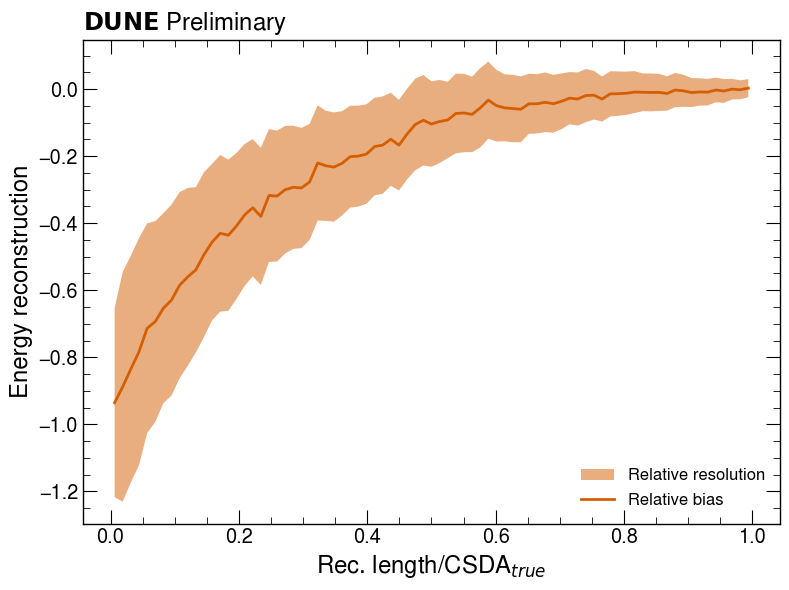

In [259]:
dftest = dfmu.filter(
    # pl.col('trkg4en').is_between(1,2),
    ~pl.col('trkIsContained')
)

plt.figure(figsize=(8,6))
# resolution_plot(dftest, labels=['Chi2'], reco='Echi2')
resolution_plot(dftest, labels=[''], reco='Ellhd', legloc='lower right')
dunestyle.Preliminary(x=0, y=1.02, ax=plt.gca(), fontsize="xx-large")
plt.savefig('./pdf/ereco_relative_length.pdf')

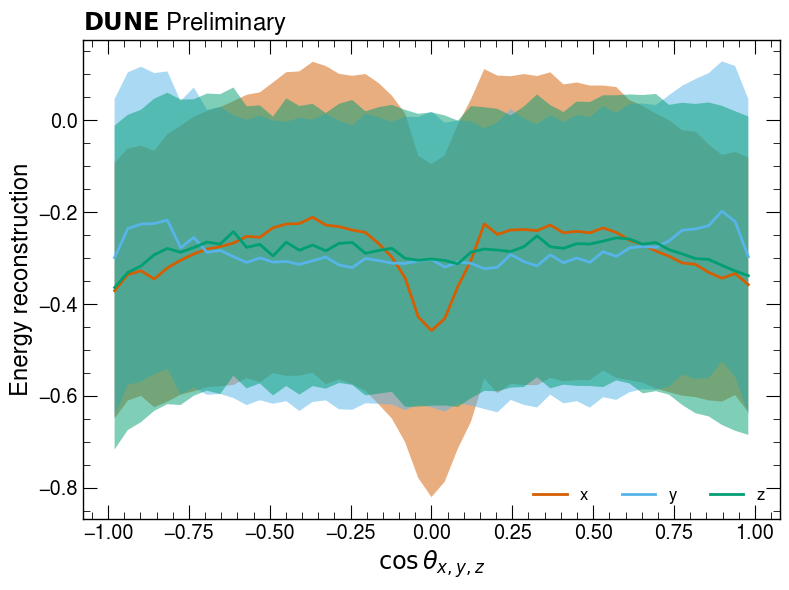

In [344]:

plt.figure(figsize=(8,6))
resolution_plot_angles(dftest, labels=['x'], true_x='trkstartdcosx', legloc='lower right', Ebins=np.linspace(-1,1,50))     
resolution_plot_angles(dftest, labels=['y'], true_x='trkstartdcosy', legloc='lower right', Ebins=np.linspace(-1,1,50))     
resolution_plot_angles(dftest, labels=['z'], true_x='trkstartdcosz', legloc='lower right', Ebins=np.linspace(-1,1,50))     

dunestyle.Preliminary(x=0, y=1.02, ax=plt.gca(), fontsize="xx-large")
plt.savefig('./pdf/ereco_direction_LLHD.pdf')

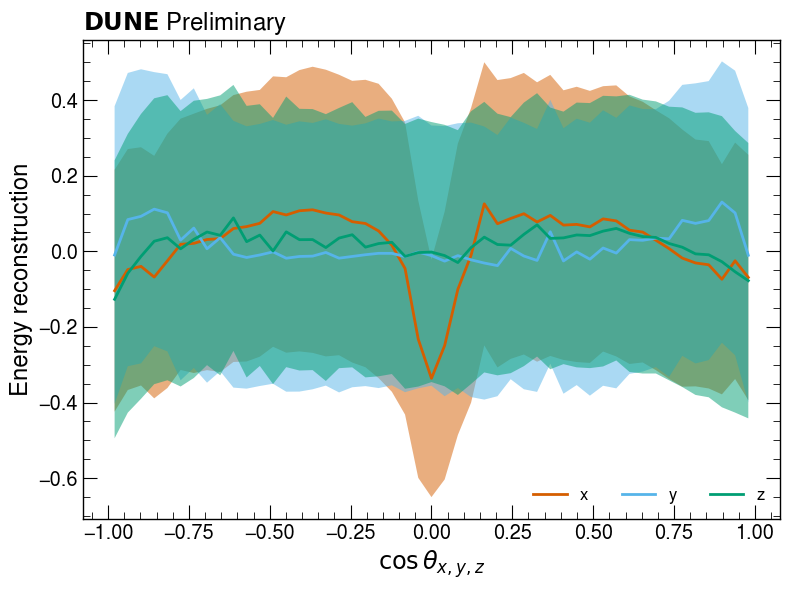

In [345]:

plt.figure(figsize=(8,6))
resolution_plot_angles(dftest, labels=['x'], reco='Echi2', true_x='trkstartdcosx', legloc='lower right', Ebins=np.linspace(-1,1,50))     
resolution_plot_angles(dftest, labels=['y'], reco='Echi2', true_x='trkstartdcosy', legloc='lower right', Ebins=np.linspace(-1,1,50))     
resolution_plot_angles(dftest, labels=['z'], reco='Echi2', true_x='trkstartdcosz', legloc='lower right', Ebins=np.linspace(-1,1,50))     

dunestyle.Preliminary(x=0, y=1.02, ax=plt.gca(), fontsize="xx-large")
plt.savefig('./pdf/ereco_direction_Chi2.pdf')

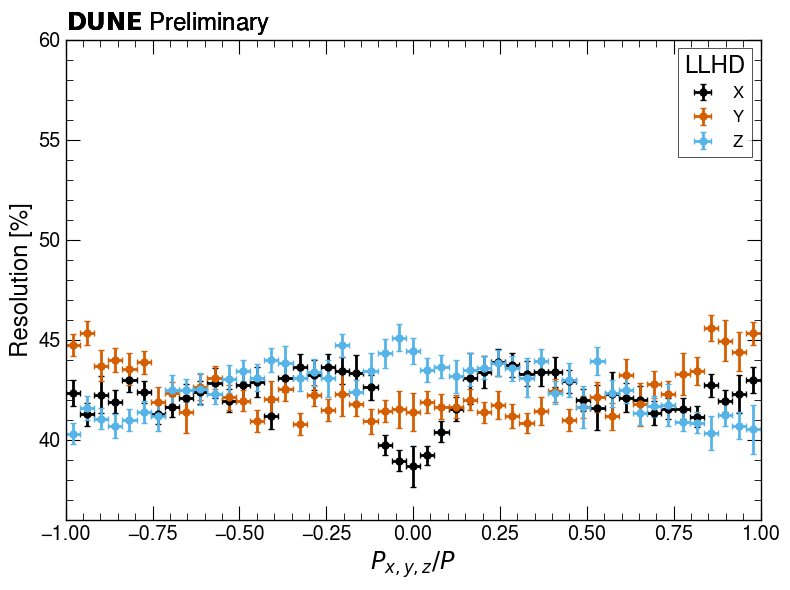

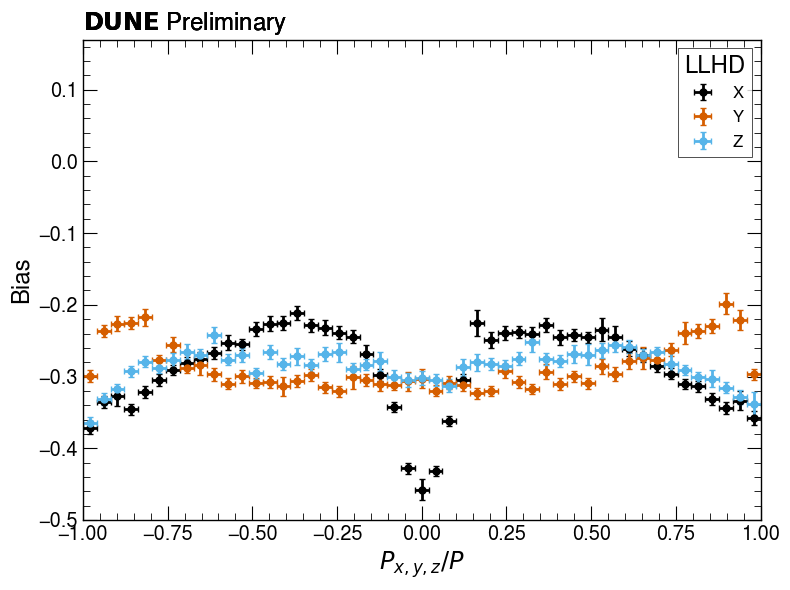

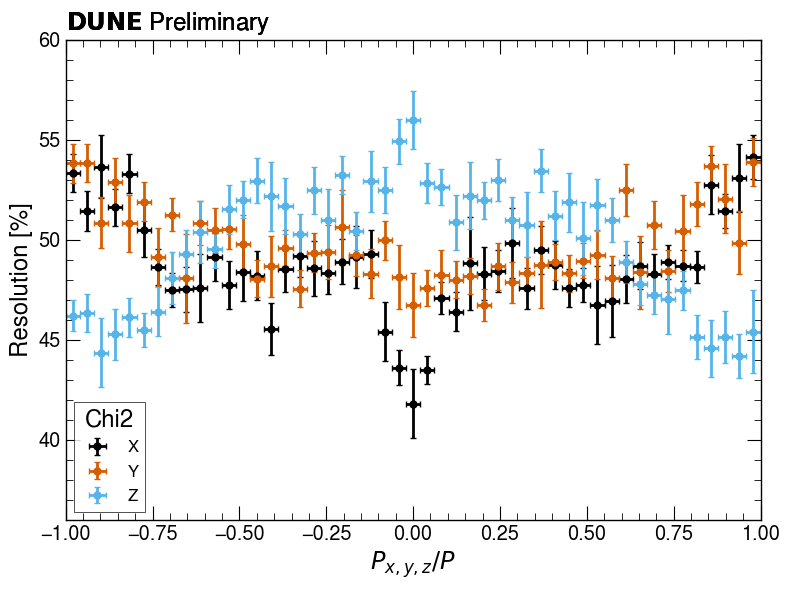

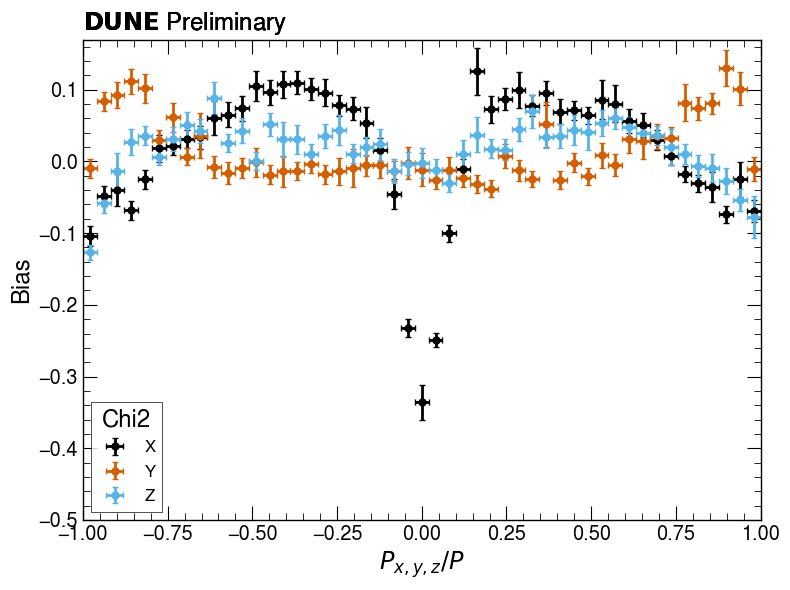

In [29]:
quick_plot_res_bias(dftest, title='LLHD', xlabel=r'$P_{x,y,z}/P$')
quick_plot_res_bias(dftest, y='Echi2', title='Chi2', xlabel=r'$P_{x,y,z}/P$')